## Importing necessary libraries

In [1]:
import tensorflow as tf
import numpy as np
import re, os
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

## Getting data from Kaggle

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d columbine/imdb-dataset-sentiment-analysis-in-csv-format
!unzip '/content/imdb-dataset-sentiment-analysis-in-csv-format.zip'

 78% 20.0M/25.7M [00:00<00:00, 42.4MB/s]
100% 25.7M/25.7M [00:00<00:00, 65.0MB/s]
Archive:  /content/imdb-dataset-sentiment-analysis-in-csv-format.zip
  inflating: Test.csv                
  inflating: Train.csv               
  inflating: Valid.csv               


In [3]:
df_train = pd.read_csv('/content/Train.csv')
df_train.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [4]:
df_val = pd.read_csv('/content/Valid.csv')
df_val.head()

,text,label
0,It's been about 14 years since Sharon Stone aw...,0
1,someone needed to make a car payment... this i...,0
2,The Guidelines state that a comment must conta...,0
3,This movie is a muddled mish-mash of clichés f...,0
4,Before Stan Laurel became the smaller half of ...,0


In [5]:
df_test = pd.read_csv('/content/Test.csv')
df_test.head()

,text,label
0,I always wrote this series off as being a comp...,0
1,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,0
2,This movie was so poorly written and directed ...,0
3,The most interesting thing about Miryang (Secr...,1
4,"when i first read about ""berlin am meer"" i did...",0


In [6]:
df_train['label'].value_counts()

0    20019
1    19981
Name: label, dtype: int64

## Preprocessing

In [7]:
# Cleaning/Preprocessing Helper function 

def preprocess(s):
  s = re.sub(r'@[a-zA-Z0-9_.]+ ', '', str(s))
  s = re.sub(r'#[a-zA-Z0-9_.]+ ', '', str(s))
  s = re.sub(r'''[^a-zA-Z0-9?. ]+''', '', s)
  s = re.sub(r''''[' ']+''', " ", s)
  s = re.sub(r'(\w)\1{2,}',r'\1',s)
  s = s.lower().strip()
  return s

In [8]:
df_train['text'] = df_train['text'].apply(preprocess)
df_val['text'] = df_val['text'].apply(preprocess)
df_test['text'] = df_test['text'].apply(preprocess)

In [9]:
def get_data(df):
  zeros, ones = df[df['label']==0], df[df['label']==1]
  zero_text, zero_labels = zeros['text'].to_numpy(), zeros['label'].to_numpy() 
  one_text, one_labels = ones['text'].to_numpy(), ones['label'].to_numpy()  
  X, Y = np.concatenate((one_text,zero_text)), np.concatenate((one_labels,zero_labels))
  return X,Y

In [10]:
X_train,Y_train = get_data(df_train)
X_val,Y_val = get_data(df_val)
X_test,Y_test = get_data(df_test)

In [11]:
X_train.shape,X_val.shape,X_test.shape

((40000,), (5000,), (5000,))

## Creating the Model

In [12]:
# Instantiating the Tokenizer and creating sequences
tokenizer = tf.keras.preprocessing.text.Tokenizer(3000,oov_token=1)
tokenizer.fit_on_texts(X_train)
train_seq = tokenizer.texts_to_sequences(X_train)
val_seq = tokenizer.texts_to_sequences(X_val)
test_seq = tokenizer.texts_to_sequences(X_test)

In [13]:
# Padding all sequences
train_seq = tf.keras.preprocessing.sequence.pad_sequences(train_seq,maxlen=50,padding='post')
val_seq = tf.keras.preprocessing.sequence.pad_sequences(val_seq,maxlen=50,padding='post')
test_seq = tf.keras.preprocessing.sequence.pad_sequences(test_seq,maxlen=50,padding='post')

## Creating the Model

In [14]:
from tensorflow.keras.layers import Embedding,Dense,LSTM,Flatten,Dropout
def create_model():
  model = tf.keras.models.Sequential()
  model.add(Embedding(3000,64))
  model.add(LSTM(32))
  model.add(Flatten())
  model.add(Dense(64,activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(32,activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(4,activation='relu'))
  model.add(Dense(1,activation='sigmoid'))
  model.summary()
  model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])
  return model

## Full Model Training

In [15]:
# HELPER FUNCTION

def plot(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['train_loss','val_loss'])
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.legend(['train_accuracy','val_accuracy'])
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.show()

In [16]:
def train_full_model(train_seq,Y_train,val_seq,Y_val,test_seq,Y_test):
  model = create_model()
  history = model.fit(train_seq,Y_train,256,15,validation_data=(val_seq,Y_val),callbacks=[tf.keras.callbacks.ModelCheckpoint('FullModelCheckpoint.h5',save_best_only=True,verbose=1),tf.keras.callbacks.EarlyStopping(patience=6,verbose=1)])
  plot(history)
  model = tf.keras.models.load_model('FullModelCheckpoint.h5')
  print(model.evaluate(test_seq,Y_test))
  return model

## Active Learning

In [17]:
# HELPER FUNCTIONS

def append_history(losses,val_losses,acc,val_acc,history):
  losses = losses + history.history['loss']
  val_losses = val_losses + history.history['val_loss']
  acc = acc + history.history['accuracy']
  val_acc = val_acc + history.history['val_accuracy']
  return losses,val_losses,acc,val_acc

def plot_merged_metrics(losses,val_losses,accuracies,val_accuracies):
  plt.plot(losses)
  plt.plot(val_losses)
  plt.legend(['train_loss','val_loss'])
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

  plt.plot(accuracies)
  plt.plot(val_accuracies)
  plt.legend(['train_accuracy','val_accuracy'])
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.show()

In [18]:
import collections

def train_small_models(train_features,train_labels,pool_features,pool_labels,val_seq,Y_val,test_seq,Y_test,iters=3,sampling_size=5000):

  losses, val_losses, accuracies, val_accuracies = [], [], [], []

  model = create_model()
  checkpoint = tf.keras.callbacks.ModelCheckpoint('Checkpoint.h5',save_best_only=True,verbose=1)

  print(f"Starting to train with {train_features.shape[0]} samples")

  history = model.fit(train_features,train_labels,256,15,validation_data=(val_seq,Y_val),callbacks=[checkpoint,tf.keras.callbacks.EarlyStopping(patience=6,verbose=1)])
  losses, val_losses, accuracies, val_accuracies = append_history(losses,val_losses,accuracies,val_accuracies,history) 
  model = tf.keras.models.load_model('Checkpoint.h5')

  for iter_n in range(iters):

    # Getting predictions from previously trained model
    predictions = model.predict(test_seq)
    rounded = np.where(predictions>0.5,1,0)

    # Count number of ones and zeros incorrectly classified
    counter = collections.Counter(Y_test[rounded.squeeze()!=Y_test.squeeze()])

    # Find ratio of ones to zeros. If all samples are correctly classified (Major overfitting) then we set the ratio to 0.5
    if counter[0]!=0 and counter[1]!=0:
      total = counter[0]+counter[1]
      sample_ratio = counter[0]/total if counter[0]>counter[1] else counter[1]/total
    else:
      sample_ratio = 0.5

    sample = np.concatenate((np.random.choice(np.where(pool_labels==0)[0],int(sample_ratio*sampling_size), replace=False),
                             np.random.choice(np.where(pool_labels==1)[0],int(sampling_size*(1-sample_ratio)), replace=False)))
    np.random.shuffle(sample)

    # Get new values from pool
    update_f = pool_features[sample]
    update_l = pool_labels[sample]

    # Remove the chosen samples from pool
    pool_features = np.delete(pool_features,sample,axis=0)
    pool_labels = np.delete(pool_labels,sample)

    # Add the sampled entries to the original data
    train_features = np.vstack((train_features,update_f))
    train_labels = np.hstack((train_labels,update_l))
    
    print(f"Starting training with {train_features.shape[0]} samples")

    # Retrain the model with inconfident and incorrect predictions only
    history = model.fit(train_features,train_labels,validation_data=(val_seq,Y_val),epochs=15,batch_size=256,callbacks=[checkpoint,tf.keras.callbacks.EarlyStopping(patience=6,verbose=1)])
    
    losses, val_losses, accuracies, val_accuracies = append_history(losses,val_losses,accuracies,val_accuracies,history) 

    model = tf.keras.models.load_model('Checkpoint.h5')
    print(model.evaluate(test_seq,Y_test))

  plot_merged_metrics(losses,val_losses,accuracies,val_accuracies)
  
  return model  

## Ensembling

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          192000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                12416     
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0

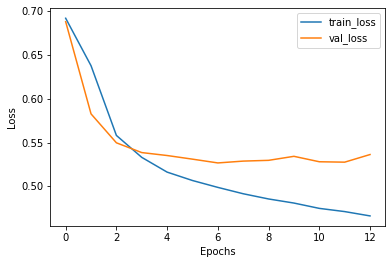

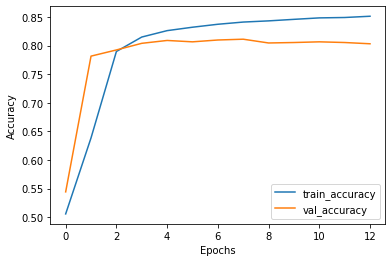

157/157 [==============================] - 1s 3ms/step - loss: 0.5324 - accuracy: 0.8088
[0.5324370265007019, 0.8087999820709229]
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          192000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2

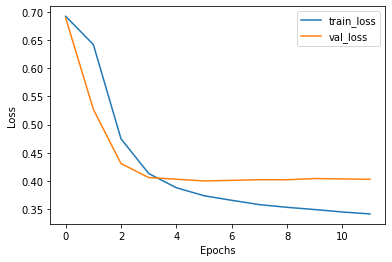

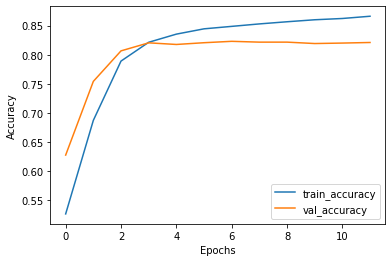

157/157 [==============================] - 1s 3ms/step - loss: 0.4020 - accuracy: 0.8202
[0.4020368158817291, 0.8202000260353088]
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          192000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
flatten_2 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2

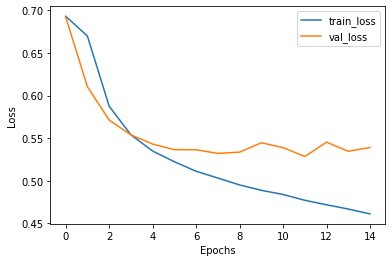

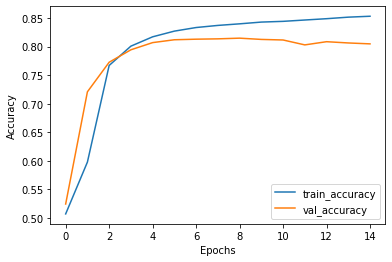

157/157 [==============================] - 0s 3ms/step - loss: 0.5235 - accuracy: 0.8140
[0.5234771370887756, 0.8140000104904175]


In [19]:
# Training 3 models for ensembling
model1 = train_full_model(train_seq,Y_train,val_seq,Y_val,test_seq,Y_test)
model2 = train_full_model(train_seq,Y_train,val_seq,Y_val,test_seq,Y_test)
model3 = train_full_model(train_seq,Y_train,val_seq,Y_val,test_seq,Y_test)

In [20]:
# # Splitting Data into Oracle Set(Unlabelled set) and Original Training set 
import sklearn.model_selection
train_features,pool_features,train_labels,pool_labels = sklearn.model_selection.train_test_split(train_seq,Y_train,test_size=0.60,stratify=Y_train)
train_features.shape,pool_features.shape

((16000, 50), (24000, 50))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 64)          192000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
flatten_3 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)               

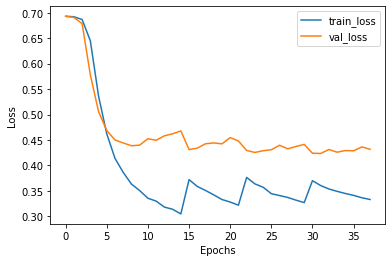

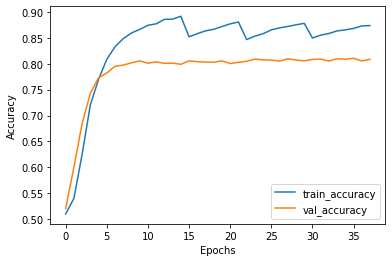

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 64)          192000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                12416     
_________________________________________________________________
flatten_4 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)               

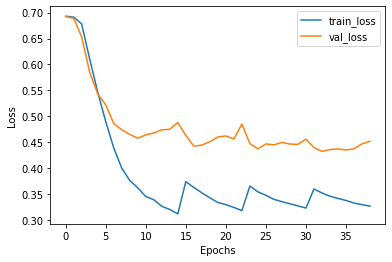

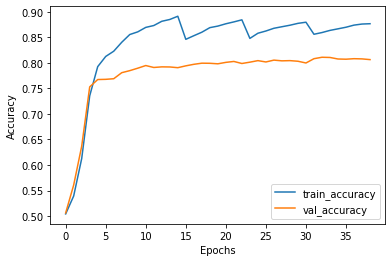

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 64)          192000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                12416     
_________________________________________________________________
flatten_5 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_11 (Dropout)         (None, 32)               

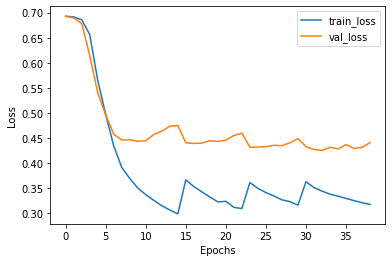

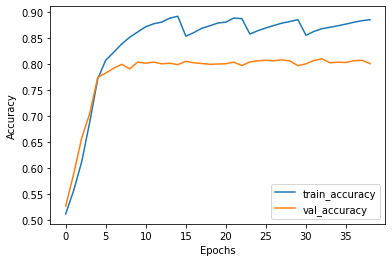

In [21]:
# Training 3 Active Learning Models for Ensembling
al_model1 = train_small_models(train_features,train_labels,pool_features,pool_labels,val_seq,Y_val,test_seq,Y_test)
al_model2 = train_small_models(train_features,train_labels,pool_features,pool_labels,val_seq,Y_val,test_seq,Y_test)
al_model3 = train_small_models(train_features,train_labels,pool_features,pool_labels,val_seq,Y_val,test_seq,Y_test)

## Predictions

In [22]:
# Ensembling by taking elementwise average

pred = (model1.predict(test_seq)+model2.predict(test_seq)+model3.predict(test_seq))/3
al_pred = (al_model1.predict(test_seq)+al_model2.predict(test_seq)+al_model3.predict(test_seq))/3

In [23]:
pred = np.where(pred<0.5,0,1)
al_pred = np.where(al_pred<0.5,0,1)
print(pred[:5],al_pred[:5])

[[1]
 [1]
 [0]
 [1]
 [1]] [[1]
 [1]
 [0]
 [1]
 [0]]


In [24]:
from sklearn.metrics import accuracy_score
print(accuracy_score(pred,Y_test))
print(accuracy_score(al_pred,Y_test))

0.8218
0.8146
